In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_train.csv
/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_validation.csv
/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_test.csv


In [1]:
import sys
print(sys.version)

#Import all required modules

#For parsing and visualizing data
from pandas import DataFrame, read_csv
import pandas as pd

#For visualizing data
import matplotlib.pyplot as plt

#For processing data
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

#Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD

#Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#For scoring
from sklearn.metrics import accuracy_score

#Progress Bar
from tqdm import tqdm

#Reloading modules that have been updated
#import importlib
#importlib.reload(baseline_features)

3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load train_stances.csv and train_bodies.csv into dataframes
train_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_train.csv")
test_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_test.csv")
valid_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_validation.csv")

# Merge train_stances and train_bodies based on the Body ID
#merged_df = pd.merge(train_stances_df, train_bodies_df, on="Body ID")

# Remove duplicate rows based on the "Body ID" column

# print(len(merged_df))

# # Stratified sampling based on the class distribution (stances)
# #train_data, test_data = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df["Stance"])
# print(len(train_data))
# print(len(test_data))

# Separate train and test instances and bodies
train_instances = train_df[["Headline", "Body ID","Stance"]]
train_bodies = train_df[["Body ID", "articleBody"]]
test_instances = test_df[["Headline", "Body ID", "Stance"]]
test_bodies = test_df[["Body ID", "articleBody"]]
test_labels = test_df["Stance"]
valid_bodies = valid_df[["Body ID", "articleBody"]]
valid_instances = valid_df[["Headline", "Body ID", "Stance"]]
valid_labels = valid_df["Stance"]

# Save train and test dataframes to CSV files
train_instances.to_csv("train_instances.csv", index=False)
train_bodies.to_csv("train_bodies.csv", index=False)
test_instances.to_csv("test_instances.csv", index=False)
test_bodies.to_csv("test_bodies.csv", index=False)
test_labels.to_csv("test_labels.csv", index=False)
valid_instances.to_csv("valid_instances.csv", index=False)
valid_bodies.to_csv("valid_bodies.csv", index=False)
valid_labels.to_csv("valid_labels.csv", index=False)

# TF-IDF VECTORISER

In [3]:
stop_words = [
        "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
        "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
        "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
        "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
        "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
        "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
        "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
        "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
        "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
        "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
        "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
        "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
        "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
        "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
        "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
        "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
        "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
        "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
        "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
        "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
        "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
        "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
        "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
        "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
        "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
        ]

In [4]:
#Adapted from https://github.com/FakeNewsChallenge/fnc-1/blob/master/scorer.py
#Original credit - @bgalbraith

LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score



## TF-IDF VECTORISER

In [5]:
#Apply Scikit Learn TFIDF Feature Extraction Algorithm
body_text_vectorizer = TfidfVectorizer(max_features= 5000, ngram_range=(1, 2), lowercase=True, stop_words='english')
headline_vectorizer = TfidfVectorizer(max_features= 5000, ngram_range=(1, 2), lowercase=True, stop_words='english')

#Create vocabulary based on training data
train_body_tfidf = body_text_vectorizer.fit_transform(train_bodies['articleBody'])
train_headline_tfidf = headline_vectorizer.fit_transform(train_instances['Headline'])

#Create vocabulary based on validation data
validate_body_tfidf = body_text_vectorizer.transform(valid_bodies['articleBody'])
validate_headline_tfidf = headline_vectorizer.transform(valid_instances['Headline'])

#Use vocabulary for testing data
test_body_tfidf = body_text_vectorizer.transform(test_bodies['articleBody'])
test_headline_tfidf = headline_vectorizer.transform(test_instances['Headline']) 


In [6]:
#Merge headline and body_text tf-idf vectors together - Stack arrays in sequence horizontally
train_features = hstack([train_body_tfidf, train_headline_tfidf])
test_features = hstack([test_body_tfidf, test_headline_tfidf])

In [7]:
print(train_features)

  (0, 938)	0.0456324902645807
  (0, 4112)	0.10802882011100504
  (0, 2649)	0.05097913150261175
  (0, 4208)	0.047305042249195
  (0, 4114)	0.05128021616444644
  (0, 3011)	0.043229707437849874
  (0, 4544)	0.044953352011797516
  (0, 2771)	0.05177445378303985
  (0, 3580)	0.05093692155437986
  (0, 1442)	0.045515720656919154
  (0, 4111)	0.04939148126001168
  (0, 4539)	0.048674334120911635
  (0, 454)	0.05106414359355232
  (0, 31)	0.03449245859074395
  (0, 4346)	0.025025253451070092
  (0, 173)	0.044280807276197535
  (0, 3260)	0.0266968736931361
  (0, 692)	0.05119317026074805
  (0, 2159)	0.050016518460514046
  (0, 2587)	0.03458269279714637
  (0, 548)	0.056058953170189565
  (0, 4578)	0.042303868892659226
  (0, 2879)	0.10744754206797393
  (0, 3547)	0.0435418185154172
  (0, 2222)	0.044321415502218554
  :	:
  (21482, 2222)	0.037177309362250006
  (21482, 1822)	0.08286027681454862
  (21482, 3205)	0.03745542742248202
  (21482, 3767)	0.1268284718975325
  (21482, 3235)	0.015064206281224717
  (21482, 1969)

In [8]:
#Extract training and test labels
train_labels = list(train_df['Stance'])
test_labels = list(test_df['Stance'])

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=10)

y_pred = rf_classifier.fit(train_features, train_labels).predict(test_features)

accuracy_score(test_labels, y_pred)

0.8629422718808194

In [23]:
report_score(test_labels,y_pred)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    259    |    16     |    50     |    43     |
-------------------------------------------------------------
| disagree  |    26     |    38     |    11     |     9     |
-------------------------------------------------------------
|  discuss  |    61     |     9     |    768    |    53     |
-------------------------------------------------------------
| unrelated |    41     |     4     |    45     |   1252    |
-------------------------------------------------------------
Score: 1421.25 out of 1678.5	(84.67381590705988%)


84.67381590705988

In [24]:
#Initialize multinomialnb classifier
nb_classifier = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

y_pred = nb_classifier.fit(train_features,train_labels).predict(test_features)

accuracy_score(test_labels, y_pred)

0.608193668528864

In [25]:
report_score(test_labels,y_pred)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    163    |    39     |    79     |    87     |
-------------------------------------------------------------
| disagree  |    11     |    36     |    15     |    22     |
-------------------------------------------------------------
|  discuss  |    40     |    70     |    569    |    212    |
-------------------------------------------------------------
| unrelated |    168    |    30     |    279    |    865    |
-------------------------------------------------------------
Score: 1047.75 out of 1678.5	(62.42180518319928%)


62.42180518319928

# Baseline Features

These features are adapted from fnc-1 challenge 

In [11]:
import os
import re
import nltk
import numpy as np
from sklearn import feature_extraction
from tqdm import tqdm


_wnl = nltk.WordNetLemmatizer()


def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
    if not os.path.isfile(feature_file):
        feats = feat_fn(headlines, bodies)
        np.save(feature_file, feats)

    return np.load(feature_file)


def word_overlap_features(headlines, bodies):
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        clean_headline = get_tokenized_lemmas(clean_headline)
        clean_body = get_tokenized_lemmas(clean_body)
        features = [
            len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))]
        X.append(features)
    return X


def refuting_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        # 'refute',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_headline = get_tokenized_lemmas(clean_headline)
        features = [1 if word in clean_headline else 0 for word in _refuting_words]
        X.append(features)
    return X


def polarity_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]

    def calculate_polarity(text):
        tokens = get_tokenized_lemmas(text)
        return sum([t in _refuting_words for t in tokens]) % 2
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        features = []
        features.append(calculate_polarity(clean_headline))
        features.append(calculate_polarity(clean_body))
        X.append(features)
    return np.array(X)


def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features


def hand_features(headlines, bodies):

    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        X.append(binary_co_occurence(headline, body)
                 + binary_co_occurence_stops(headline, body)
                 + count_grams(headline, body))


    return X

In [14]:
train_hand_features = hand_features(train_df['Headline'],train_df['articleBody'])
test_hand_features = hand_features(test_df['Headline'],test_df['articleBody'])
train_hand_features = np.array(train_hand_features)
test_hand_features = np.array(test_hand_features)

#Extract training and test labels
train_labels = list(train_df['Stance'])
test_labels = list(test_df['Stance'])

21483it [02:02, 175.92it/s]
2685it [00:15, 172.73it/s]


In [15]:
val_hand_features = hand_features(valid_df['Headline'],valid_df['articleBody'])
val_hand_features = np.array(val_hand_features)
val_features = hstack([validate_body_tfidf, validate_headline_tfidf, val_hand_features])

2686it [00:15, 177.16it/s]


In [16]:
test_df['stance_cat'] = test_df['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
test_df['Stance'].value_counts()
test_labels = list(test_df['stance_cat'])

In [17]:
valid_df['stance_cat'] = valid_df['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
valid_df['Stance'].value_counts()
val_labels = list(valid_df['stance_cat'])

In [19]:
train_df['stance_cat'] = train_df['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
train_df['Stance'].value_counts()
train_labels = list(train_df['stance_cat'])

# Polarity Features 

In [29]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [32]:
train_polarity_features = polarity_features(train_df['Headline'],train_df['articleBody'])
validate_polarity_features = polarity_features(valid_df['Headline'],valid_df['articleBody'])
test_polarity_features = polarity_features(test_df['Headline'],test_df['articleBody'])
train_polarity_features = np.array(train_polarity_features)
validate_polarity_features = np.array(validate_polarity_features)
test_polarity_features = np.array(test_polarity_features)

21483it [02:03, 174.61it/s]
2686it [00:15, 173.91it/s]
2685it [00:15, 171.32it/s]


## Refuting Features

In [35]:
train_refuting_features = refuting_features(train_df['Headline'],train_df['articleBody'])
validate_refuting_features = refuting_features(valid_df['Headline'],valid_df['articleBody'])
test_refuting_features = refuting_features(test_df['Headline'],test_df['articleBody'])
train_refuting_features = np.array(train_refuting_features)
validate_refuting_features = np.array(validate_refuting_features)
test_refuting_features = np.array(test_refuting_features)

21483it [00:05, 3955.41it/s]
2686it [00:00, 4085.27it/s]
2685it [00:00, 4098.19it/s]


## Concat Features

In [37]:
train_features = hstack([
                            train_body_tfidf,
                            train_headline_tfidf,
                            train_hand_features,
                            train_polarity_features,
                            train_refuting_features
    
                        ])
val_features = hstack([
                            validate_body_tfidf,
                            validate_headline_tfidf,
                            val_hand_features,
                            validate_polarity_features,
                            validate_refuting_features
                            
                        ])
test_features = hstack([
                            test_body_tfidf,
                            test_headline_tfidf,
                            test_hand_features,
                            test_polarity_features,
                            test_refuting_features
                        ])

In [53]:
#Initialize random forest classifier (Scikit Learn)
rf_classifier = RandomForestClassifier(n_estimators=10)

y_pred = rf_classifier.fit(train_features, list(train_df['Stance'])).predict(test_features)

report_score(list(test_df['Stance']), y_pred)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    261    |    11     |    80     |    16     |
-------------------------------------------------------------
| disagree  |    24     |    37     |    18     |     5     |
-------------------------------------------------------------
|  discuss  |    40     |    14     |    805    |    32     |
-------------------------------------------------------------
| unrelated |    11     |     3     |    30     |   1298    |
-------------------------------------------------------------
Score: 1474.25 out of 1678.5	(87.83139708072684%)


87.83139708072684

In [58]:
from sklearn.metrics import precision_recall_fscore_support
accuracy = accuracy_score(list(test_df['Stance']), y_pred)
# Calculate precision, recall, F1-score for each class using scikit-learn
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
precision_binorm, recall_binorm, f1_score_binorm, _ = precision_recall_fscore_support(list(test_df['Stance']), y_pred, average=None)

# Print class-wise F1 scores
for i in range(len(precision_binorm)):
    print(f"Class {i} - Precision: {precision_binorm[i]}, Recall: {recall_binorm[i]}, F1-score: {f1_score_binorm[i]}")

# Print all the metrics
print("Accuracy:", accuracy)
print("Macro Precision:", precision_binorm.mean())
print("Macro Recall:", recall_binorm.mean())
print("Macro F1 Score:", f1_score_binorm.mean())


Class 0 - Precision: 0.7767857142857143, Recall: 0.7092391304347826, F1-score: 0.7414772727272728
Class 1 - Precision: 0.5692307692307692, Recall: 0.44047619047619047, F1-score: 0.4966442953020134
Class 2 - Precision: 0.8628081457663451, Recall: 0.9034792368125701, F1-score: 0.8826754385964912
Class 3 - Precision: 0.9607698001480385, Recall: 0.9672131147540983, F1-score: 0.9639806906795395
Accuracy: 0.8942271880819367
Macro Precision: 0.7923986073577167
Macro Recall: 0.7551019181194104
Macro F1 Score: 0.7711944243263293


In [59]:
#Initialize multinomialnb classifier
nb_classifier = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

y_pred = nb_classifier.fit(train_features,list(train_df['Stance'])).predict(test_features)

report_score(list(test_df['Stance']), y_pred)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    226    |    16     |    102    |    24     |
-------------------------------------------------------------
| disagree  |    43     |    16     |    20     |     5     |
-------------------------------------------------------------
|  discuss  |    122    |    26     |    697    |    46     |
-------------------------------------------------------------
| unrelated |    31     |     5     |    67     |   1239    |
-------------------------------------------------------------
Score: 1331.0 out of 1678.5	(79.29699136133452%)


79.29699136133452

In [60]:
from sklearn.metrics import precision_recall_fscore_support
accuracy = accuracy_score(list(test_df['Stance']), y_pred)
# Calculate precision, recall, F1-score for each class using scikit-learn
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
precision_binorm, recall_binorm, f1_score_binorm, _ = precision_recall_fscore_support(list(test_df['Stance']), y_pred, average=None)

# Print class-wise F1 scores
for i in range(len(precision_binorm)):
    print(f"Class {i} - Precision: {precision_binorm[i]}, Recall: {recall_binorm[i]}, F1-score: {f1_score_binorm[i]}")

# Print all the metrics
print("Accuracy:", accuracy)
print("Macro Precision:", precision_binorm.mean())
print("Macro Recall:", recall_binorm.mean())
print("Macro F1 Score:", f1_score_binorm.mean())


Class 0 - Precision: 0.5355450236966824, Recall: 0.6141304347826086, F1-score: 0.5721518987341772
Class 1 - Precision: 0.25396825396825395, Recall: 0.19047619047619047, F1-score: 0.21768707482993196
Class 2 - Precision: 0.7866817155756207, Recall: 0.7822671156004489, F1-score: 0.7844682048396173
Class 3 - Precision: 0.9429223744292238, Recall: 0.9232488822652757, F1-score: 0.9329819277108433
Accuracy: 0.8111731843575419
Macro Precision: 0.6297793419174452
Macro Recall: 0.6275306557811309
Macro F1 Score: 0.6268222765286424


In [57]:
test_features.shape

(2685, 10026)

# MLP

In [61]:
X_train = np.array(train_features.toarray())
X_val = np.array(val_features.toarray())
X_test = np.array(test_features.toarray())

In [64]:
X_train.shape

(21483, 10043)

In [66]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf

# Define your hand-crafted features (train_hand_features and test_hand_features)
# train_hand_features and test_hand_features should be numpy arrays

# Concatenate the TF-IDF vectors and hand-crafted features for train and test sets

# Perform a stratified split of data into train and validation sets

# Define input shape
input_similarity = tf.keras.Input(shape=(X_train.shape[1],), name='input_similarity')

# Dense layer
dense1 = tf.keras.layers.Dense(64, activation='relu')(input_similarity)

# Dropout layer
drop = tf.keras.layers.Dropout(0.5)(dense1)

# Output layer
output = tf.keras.layers.Dense(4, activation='softmax')(drop)

# Create model
model = tf.keras.Model(inputs=input_similarity, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_similarity (InputLayer)   │ (None, 10043)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       642,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,076 (2.45 MB)

 Trainable params: 643,076 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Train model
history = model.fit(X_train, np.array(train_labels), validation_data=(X_val, np.array(val_labels)), epochs=40, batch_size=64)

Epoch 1/40
 69/336 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6209 - loss: 1.0361

I0000 00:00:1713090794.098171      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713090794.113228      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7397 - loss: 0.7432

W0000 00:00:1713090797.171224      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7399 - loss: 0.7427 - val_accuracy: 0.8667 - val_loss: 0.3808
Epoch 2/40
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8670 - loss: 0.3689 - val_accuracy: 0.8846 - val_loss: 0.2998
Epoch 3/40
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9025 - loss: 0.2762 - val_accuracy: 0.9103 - val_loss: 0.2474
Epoch 4/40
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9180 - loss: 0.2298 - val_accuracy: 0.9259 - val_loss: 0.2104
Epoch 5/40
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9329 - loss: 0.1913 - val_accuracy: 0.9319 - val_loss: 0.1894
Epoch 6/40
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9407 - loss: 0.1671 - val_accuracy: 0.9337 - val_loss: 0.1884
Epoch 7/40
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9502 - loss: 0.1404 - val_accuracy: 0.9401 - val_loss: 0.1667
Epoch 8/40
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9621 - loss: 0.1207 - val_accuracy: 0.9460 - val

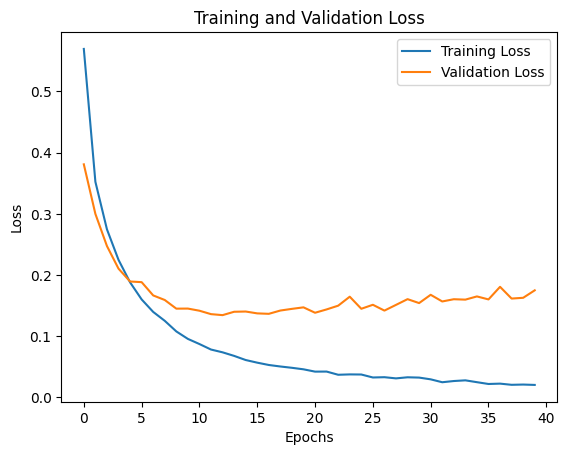

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9622 - loss: 0.1913
Test Loss: 0.2007075995206833
Test Accuracy: 0.9590316414833069


In [68]:
# Save the training history
import matplotlib.pyplot as plt
training_loss_binorm = history.history['loss']
validation_loss_binorm = history.history['val_loss']

# Plot the loss
plt.plot(training_loss_binorm, label='Training Loss')
plt.plot(validation_loss_binorm, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_binorm, accuracy_binorm = model.evaluate(X_test, np.array(test_labels))
print('Test Loss:', loss_binorm)
print('Test Accuracy:', accuracy_binorm)

In [69]:
# Evaluate model on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
test_accuracy = accuracy_score(test_labels, y_pred_classes)
print("Test Accuracy:", test_accuracy)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.9590316573556797


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


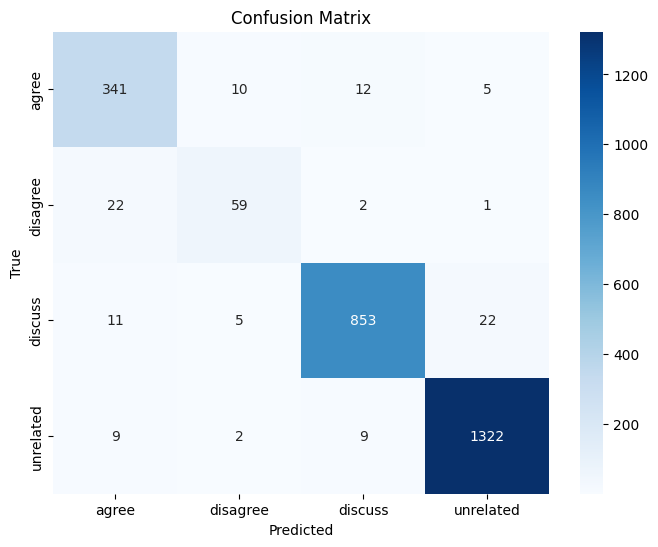

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Score: 2260.0 out of 2349.5	(96.19067886784423%)
Accuracy: 0.9590316573556797
Precision: 0.958892933050825
Recall: 0.9590316573556797
F1 Score: 0.9588273706701376
Custom Score: 2260.0
Class 0 - Precision: 0.8903394255874674, Recall: 0.9266304347826086, F1-score: 0.9081225033288949
Class 1 - Precision: 0.7763157894736842, Recall: 0.7023809523809523, F1-score: 0.7374999999999999
Class 2 - Precision: 0.973744292237443, Recall: 0.957351290684624, F1-score: 0.9654782116581777
Class 3 - Precision: 0.9792592592592593, Recall: 0.9850968703427719, F1-score: 0.9821693907875185


(0.9590316573556797,
 0.958892933050825,
 0.9590316573556797,
 0.9588273706701376,
 2260.0)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

class ModelEvaluator:
    def __init__(self, model, test_set, true_labels):
        self.model = model
        self.test_set = test_set
        self.true_labels = true_labels

    def plot_confusion_matrix(self):
        predictions = self.model.predict(np.stack(self.test_set))
        predicted_labels = np.argmax(predictions, axis=1)
        conf_matrix = confusion_matrix(self.true_labels, predicted_labels)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
                    yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def calculate_metrics(self):
        predictions = self.model.predict(np.stack(self.test_set))
        predicted_labels = np.argmax(predictions, axis=1)

        acc = accuracy_score(self.true_labels, predicted_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(self.true_labels, predicted_labels, average='weighted')

        def score_submission(gold_labels, test_labels):
            score = 0.0

            for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
                g_stance, t_stance = g, t
                if g_stance == t_stance:
                    score += 0.25
                    if g_stance != 'unrelated':
                        score += 0.50
                if g_stance in [0, 1, 2] and t_stance in [0, 1, 2]:
                    score += 0.25

            return score
        
        def report_score(actual,predicted):
            score = score_submission(actual,predicted)
            best_score = score_submission(actual,actual)

            print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
            return score*100/best_score

        custom_score = score_submission(self.true_labels, predicted_labels)
        report_sc = report_score(self.true_labels, predicted_labels)

        return acc, precision, recall, f1, custom_score, predicted_labels

    def evaluate(self):
        self.plot_confusion_matrix()
        acc, precision, recall, f1, custom_score, predicted_labels = self.calculate_metrics()

        print("Accuracy:", acc)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("Custom Score:", custom_score)

        class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(self.true_labels, predicted_labels, average=None)
        for i in range(len(class_precision)):
            print(f"Class {i} - Precision: {class_precision[i]}, Recall: {class_recall[i]}, F1-score: {class_f1[i]}")

        return acc, precision, recall, f1, custom_score

# Assuming `model_lstm` is the trained model, `test_set` is the test set, and `stan` are the true labels
evaluator = ModelEvaluator(model, X_test, np.array(test_labels))
evaluator.evaluate()


In [73]:
print(np.array(test_labels))

[1 3 3 ... 2 3 3]
